In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.eager as tfe

In [3]:
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = (12, 8)

In [4]:
tf.enable_eager_execution()

In [5]:
print("Tensorflow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

Tensorflow version: 1.10.0
Eager execution: True


---

In [6]:
train_dataset_url = "http://download.tensorflow.org/data/iris_training.csv"

In [7]:
train_dataset_fp = tf.keras.utils.get_file(fname= os.getcwd() + '/data/' + os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

In [8]:
print("Local copy of the dataset file: {}".format(train_dataset_fp))

Local copy of the dataset file: C:\Users\Jeremy\Documents\Programming\data_science\propulsion\class-work\week7.8\day9.10/data/iris_training.csv


In [9]:
!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


In [10]:
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

In [11]:
label_name = column_names.pop(column_names.index('species'))

In [12]:
feature_names = column_names

In [13]:
print('Features: {}'.format(feature_names))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']


In [14]:
print('Label: {}'.format(label_name))

Label: species


In [15]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris verginica']

---

In [16]:
BATCH_SIZE = 32

In [17]:
train_dataset = tf.contrib.data.make_csv_dataset(train_dataset_fp,
                                                 batch_size = BATCH_SIZE,
                                                 column_names = feature_names + [label_name],
                                                 label_name = label_name,
                                                 num_epochs = 1)

In [18]:
features, labels = next(iter(train_dataset))

---

Text(0,0.5,'Sepal length')

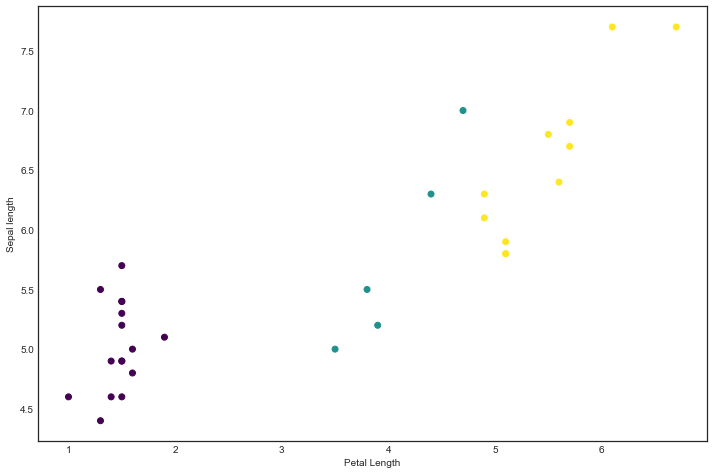

In [19]:
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels,
            cmap='viridis')
plt.xlabel('Petal Length')
plt.ylabel('Sepal length')

---

In [20]:
# Simplify model building step
def pack_features_vector(features_, labels_):
    features_ = tf.stack(list(features_.values()), axis=1)
    return features_, labels_

In [21]:
train_dataset = train_dataset.map(pack_features_vector)

In [22]:
features, labels = next(iter(train_dataset))

print(features)

tf.Tensor(
[[5.5 3.5 1.3 0.2]
 [5.8 4.  1.2 0.2]
 [7.7 2.6 6.9 2.3]
 [4.9 3.1 1.5 0.1]
 [5.8 2.7 5.1 1.9]
 [6.7 3.  5.  1.7]
 [6.2 3.4 5.4 2.3]
 [5.1 3.7 1.5 0.4]
 [5.  3.5 1.6 0.6]
 [7.2 3.2 6.  1.8]
 [5.5 2.6 4.4 1.2]
 [6.1 3.  4.9 1.8]
 [6.  3.  4.8 1.8]
 [6.4 3.2 4.5 1.5]
 [5.6 2.5 3.9 1.1]
 [5.  3.3 1.4 0.2]
 [6.3 3.3 6.  2.5]
 [6.  2.7 5.1 1.6]
 [4.9 3.1 1.5 0.1]
 [6.5 3.  5.2 2. ]
 [5.8 2.6 4.  1.2]
 [5.7 3.8 1.7 0.3]
 [6.4 2.8 5.6 2.2]
 [6.3 2.5 5.  1.9]
 [5.4 3.9 1.3 0.4]
 [5.  3.5 1.3 0.3]
 [7.4 2.8 6.1 1.9]
 [4.9 2.5 4.5 1.7]
 [7.2 3.  5.8 1.6]
 [6.4 2.8 5.6 2.1]
 [5.7 2.9 4.2 1.3]
 [5.4 3.7 1.5 0.2]], shape=(32, 4), dtype=float32)


In [23]:
L = tf.keras.layers
model = tf.keras.Sequential([
    L.Dense(10, activation=tf.nn.relu, input_dim=4),
    L.Dense(10, activation=tf.nn.relu),
    L.Dense(3)
])

In [24]:
predictions = model(features)

softmax_predictions = tf.nn.softmax(predictions)

print("Predictions: \t{}".format(tf.argmax(softmax_predictions, axis=1)))
print("Labels: \t{}".format(labels))

Predictions: 	[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Labels: 	[0 0 2 0 2 1 2 0 0 2 1 2 2 1 1 0 2 1 0 2 1 0 2 2 0 0 2 2 2 2 1 0]


---

In [25]:
def loss(model_, x_, y_):
    yhat = model(x_)
    return tf.losses.sparse_softmax_cross_entropy(labels=y_, logits=yhat)

In [26]:
l = loss(model, features, labels)
print("Loss test: {}".format(l))

Loss test: 1.3487513065338135


In [27]:
def grad(model_, inputs_, targets_):
    with tf.GradientTape() as tape:
        loss_value = loss(model_, inputs_, targets_)
    return loss_value, tape.gradient(loss_value, model_.trainable_variables)

In [28]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.01)
global_step = tf.train.get_or_create_global_step()

In [29]:
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(global_step.numpy(),
                                          loss_value.numpy()))

Step: 0, Initial Loss: 1.3487513065338135


In [30]:
optimizer.apply_gradients(zip(grads, model.variables), global_step)

print("Step: {}, \tLoss: {}".format(global_step.numpy(),
                                    loss(model, features,
                                         labels).numpy()))

Step: 1, 	Loss: 1.2331790924072266


---

In [31]:
train_loss_results = []
train_accuracy_results = []

num_epochs = 401

for epoch in range(num_epochs):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()
    
    for x, y in train_dataset:
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.variables),
                                  global_step)
        
        epoch_loss_avg(loss_value)
        epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)
        
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    if epoch % 50 == 0:
        print("Epoch {:03d}: \tLoss: {:.3f}, Accuracy: {:.3%}".format(epoch, 
                                                                      epoch_loss_avg.result(),
                                                                      epoch_accuracy.result()))

Epoch 000: 	Loss: 1.228, Accuracy: 25.833%
Epoch 050: 	Loss: 0.467, Accuracy: 84.167%
Epoch 100: 	Loss: 0.253, Accuracy: 97.500%
Epoch 150: 	Loss: 0.174, Accuracy: 97.500%
Epoch 200: 	Loss: 0.133, Accuracy: 97.500%
Epoch 250: 	Loss: 0.122, Accuracy: 98.333%
Epoch 300: 	Loss: 0.100, Accuracy: 97.500%
Epoch 350: 	Loss: 0.097, Accuracy: 97.500%
Epoch 400: 	Loss: 0.092, Accuracy: 97.500%


---

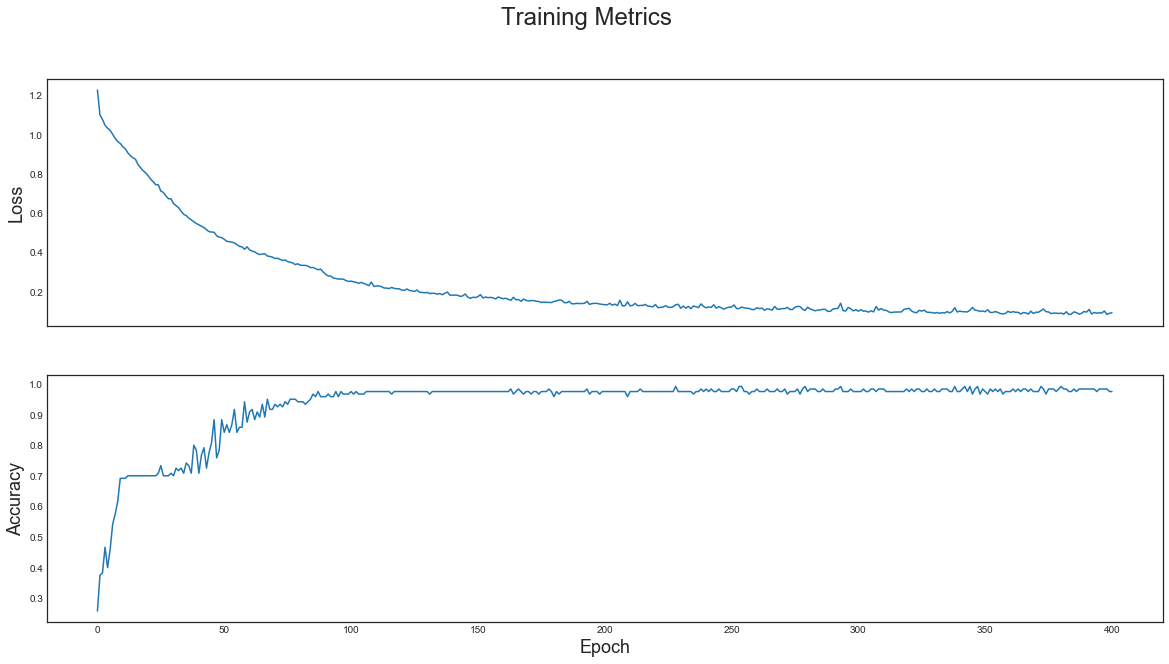

In [32]:
fig, axes = plt.subplots(2, sharex=True, figsize=(20, 10))
fig.suptitle("Training Metrics", fontsize=24)

label_size=18
axes[0].set_ylabel('Loss', fontsize=label_size)
axes[0].plot(train_loss_results)

axes[1].set_ylabel('Accuracy', fontsize=label_size)
axes[1].set_xlabel('Epoch', fontsize=label_size)
axes[1].plot(train_accuracy_results)

None

---

In [33]:
test_url = "http://download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.getcwd() + '/data/' + os.path.basename(test_url),
                            origin=test_url)

In [34]:
test_dataset = tf.contrib.data.make_csv_dataset(test_fp,
                                                batch_size=BATCH_SIZE,
                                                column_names=feature_names + [label_name],
                                                label_name=label_name,
                                                num_epochs=1,
                                                shuffle=False)

In [35]:
test_dataset = test_dataset.map(pack_features_vector)

In [36]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in test_dataset:
    logits = model(x)
    prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
    test_accuracy(prediction, y)
    
print("Test accuracy: {:.3%}".format(test_accuracy.result()))

Test accuracy: 96.667%


In [37]:
tf.stack([y, prediction], axis=1)

<tf.Tensor: id=229161, shape=(30, 2), dtype=int32, numpy=
array([[1, 1],
       [2, 2],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [2, 1],
       [1, 1],
       [2, 2],
       [2, 2],
       [0, 0],
       [2, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1]])>

---

In [38]:
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5],
    [5.9, 3.0, 4.2, 1.5],
    [6.9, 3.1, 5.4, 2.1]
])

In [39]:
predictions = model(predict_dataset)

In [40]:
for i, logits in enumerate(predictions):
    class_idx = tf.argmax(logits).numpy()
    p = tf.nn.softmax(logits)[class_idx]
    name = class_names[class_idx]
    print("Example {} prediction: {} ({:2.1f}%)".format(i, name, 100*p))

Example 0 prediction: Iris setosa (99.3%)
Example 1 prediction: Iris versicolor (98.5%)
Example 2 prediction: Iris verginica (72.7%)
